In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from os import path
import glob

from src.utils import *
from src.forward_model import *

In [2]:
obj_dims = (648, 486)

In [3]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

# Ground truth record path
gt_path = path.join('/home/rshuai/research/u-net-reconstruction/data/datasets/dataset_1/ground_truths')
gt_files = glob.glob(path.join(gt_path, '*'))

In [4]:
# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

In [5]:
# TFRecord Utils
feature_description = {
    'plane': tf.io.FixedLenFeature(obj_dims, tf.float32)
}
def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [6]:
raw_dataset = tf.data.TFRecordDataset(filenames=gt_files)
dataset = raw_dataset.map(_parse_function)

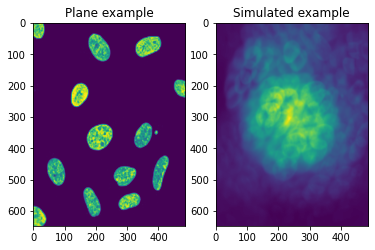

In [7]:
# Visualize a random example and its simulation under the forward model
dataset_iter = iter(dataset.shuffle(32))
plane_example = next(dataset_iter)['plane'].numpy()

model = ForwardModel()
sim_example = model.A_svd_2d_tf(plane_example, weights, h)

fig = plt.figure()

ax1 = plt.subplot(121)
ax1.imshow(plane_example)
ax1.set_title("Plane example")

ax2 = plt.subplot(122)
ax2.imshow(sim_example)
ax2.set_title("Simulated example")

plt.show()

# Toy data (temp)

In [8]:
from skimage import color, data, restoration
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import convolve2d
import tensorflow as tf
import scipy.io as sio

from scipy import signal
import skimage.registration

from PIL import Image
import PIL

In [9]:
def A_svd_2d_tf_temp(v, h, weights=None):
    if weights is None:
        weights = tf.ones(shape=tf.shape(h))

    v = tf.dtypes.cast(v, dtype=tf.complex64)
    weights = tf.dtypes.cast(weights, dtype=tf.complex64)
    h = tf.dtypes.cast(h, dtype=tf.complex64)

    v_pad = pad_2d_tf(v[None, None, ...])
    weights_pad = pad_2d_tf(weights)
    V = tf.signal.fft2d(tf.signal.ifftshift(weights_pad*v_pad, axes=(2, 3)))
    H = tf.signal.fft2d(tf.signal.ifftshift(pad_2d_tf(h), axes=(2, 3)))
    Y = V*H
    y = crop_2d_tf(tf.math.reduce_sum(tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(Y), axes=(2, 3))), axis=(0, 1)))

    return y

# Wiener Deconvolution

For now, I am using shift invariant by not including weights and just summing up over H. 

In [11]:
def my_wiener_deconv_tf(y2d, psf, K):
    # #using the central PSF to get the answer
    y2d = tf.dtypes.cast(y2d, dtype=tf.complex64)
    psf = tf.dtypes.cast(psf, dtype=tf.complex64)

    Y=tf.signal.fft2d((pad_2d_tf(y2d[None, None, ...])))
#     Y = tf.signal.fft2d(y2d)
    H_sum=tf.signal.fft2d((pad_2d_tf(psf[None, None, ...])))#np.sum(H,2)

#     K=2000 #this variable can be learned, it has be greater than zero though

    X=(tf.math.conj(H_sum)*Y)/tf.dtypes.cast(tf.math.square(tf.math.abs(H_sum))+K, dtype=tf.complex64)
    x=tf.squeeze(tf.math.real((tf.signal.ifftshift(tf.signal.ifft2d(X), axes=(2, 3)))))

    return crop_2d_tf(x)

In [12]:
img_sim = A_svd_2d_tf_temp(plane_example, tf.math.reduce_sum(h, axis=(0, 1), keepdims=True))

In [13]:
img_deconvolved = my_wiener_deconv_tf(img_sim, tf.math.reduce_sum(h, axis=(0, 1)), 1)

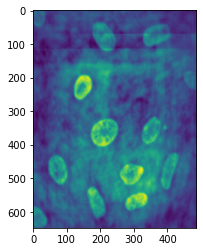

In [14]:
plt.imshow(img_deconvolved)
plt.show()

# Richardson-Lucy Deconvolution (Shift-invariant)

For now, this only implements the Richardson-Lucy deconv for shift invariant PSF to make sure things are working. We can look at how this shift invariant approximation works for a shift-varying model, and then we can look at shift-varying RL deconv too.

In [15]:
def convolve_tf(x, psf):
    """
    Frequency domain convolution.
    
    Inputs:
      - x: input image of shape (y, x)
      - psf: psf of shape (y, x)
    """
    x = tf.dtypes.cast(x, dtype=tf.complex64)
    psf = tf.dtypes.cast(psf, dtype=tf.complex64)
    
    X = tf.signal.fft2d(tf.signal.ifftshift(pad_2d_tf(x)))
    H = tf.signal.fft2d(tf.signal.ifftshift(pad_2d_tf(psf)))
    
    X = X*H
    X = crop_2d_tf(tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(X))))
    
    return X

In [146]:
def richardson_lucy(img, psf, max_iters, filter_epsilon=None):
    """
    img: Image to be deconvolved, shape (y, x)
    psf: PSF, shape (y, x)
    max_iters: Max iterations for RL deconvolution, plays role in regularization
    """
    assert len(img.shape) == 2, 'img should be of shape (y, x), but got {}'.format(img.shape)
    assert len(psf.shape) == 2, 'psf should be of shape (y, x), but got {}'.format(psf.shape)
    
#     u_t = np.full(img.shape, 0.5)
    u_t = my_wiener_deconv_tf(img_sim, tf.math.reduce_sum(h, axis=(0, 1)), 1)
    psf_mirror = np.flip(psf)
    
    for t in range(max_iters):
        c_t = convolve_tf(u_t, psf)
        
        if filter_epsilon:
            relative_blur = np.where(c_t < filter_epsilon, 0, img / c_t)
        else:
            relative_blur = img / c_t
        
        u_t = u_t * convolve_tf(relative_blur, psf_mirror)
    
    return u_t    

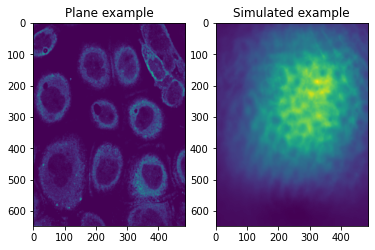

In [151]:
# Visualize a random example and its simulation under the forward model
dataset_iter = iter(dataset.shuffle(32))
plane_example = next(dataset_iter)['plane'].numpy()

model = ForwardModel()
sim_example = model.A_svd_2d_tf(plane_example, weights, h)

fig = plt.figure()

ax1 = plt.subplot(121)
ax1.imshow(plane_example)
ax1.set_title("Plane example")

ax2 = plt.subplot(122)
ax2.imshow(sim_example)
ax2.set_title("Simulated example")

plt.show()

In [178]:
def richardson_lucy(img, psf, max_iters, filter_epsilon=None, init_method='full', init_value=0.5, i=0):
    """
    img: Image to be deconvolved, shape (y, x)
    psf: PSF, shape (y, x)
    max_iters: Max iterations for RL deconvolution, plays role in regularization
    """
    assert len(img.shape) == 2, 'img should be of shape (y, x), but got {}'.format(img.shape)
    assert len(psf.shape) == 2, 'psf should be of shape (y, x), but got {}'.format(psf.shape)
    
    if init_method == 'full':
        u_t = np.full(img.shape, init_value)
    elif init_method == 'wiener':
        u_t = my_wiener_deconv_tf(img, psfs[i], 1)
    else:
        assert False, 'Initialization method {} not implemented'.format(init_method)
    psf_mirror = np.flip(psf)
    
    for t in range(max_iters):
        c_t = convolve_tf(u_t, psf)
        
        if filter_epsilon:
            relative_blur = np.where(c_t < filter_epsilon, 0, img / c_t)
        else:
            relative_blur = img / c_t
        
        u_t = u_t * convolve_tf(relative_blur, psf_mirror)
    
    return u_t    

In [179]:
psf = tf.math.reduce_sum(h, axis=(0, 1), keepdims=True)
img_sim = A_svd_2d_tf_temp(plane_example, psf)

In [180]:
# UNet multiwiener
registered_psfs_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/9_psfs/psfs_Z1_1_9_registered.npy'

# psfs = np.load(registered_psfs_path).transpose([1, 2, 0])
psfs = np.load(registered_psfs_path)
assert psfs.shape == (9, 648, 486)

Ks = np.ones((1, 1, 9))

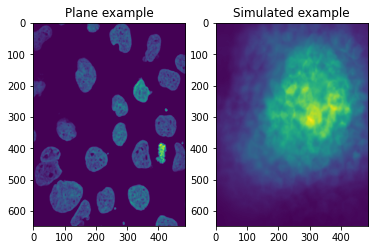

Iteration 0


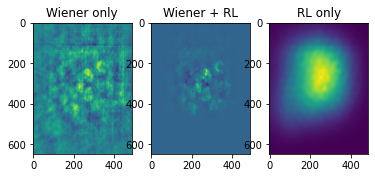

Iteration 1


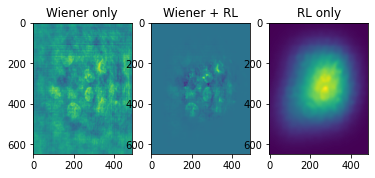

Iteration 2


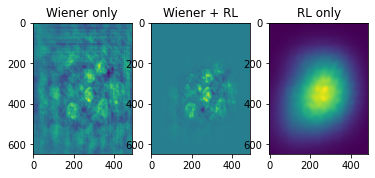

Iteration 3


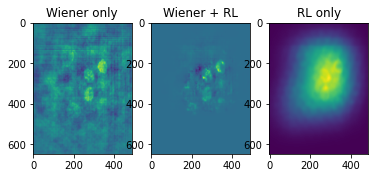

Iteration 4


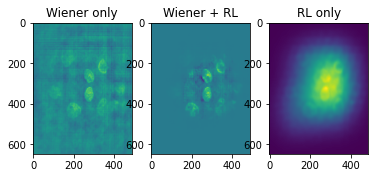

Iteration 5


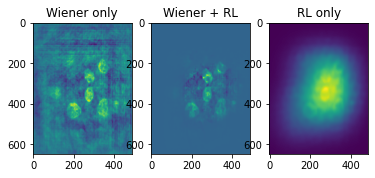

Iteration 6


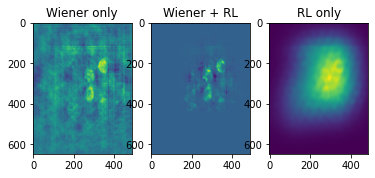

Iteration 7


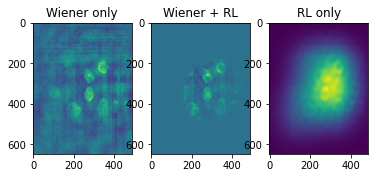

Iteration 8


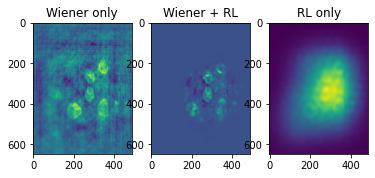

In [186]:
# Visualize a random example and its simulation under the forward model
dataset_iter = iter(dataset.shuffle(32))

plane_example = next(dataset_iter)['plane'].numpy()
model = ForwardModel()
sim_example = model.A_svd_2d_tf(plane_example, weights, h)

fig = plt.figure()

ax1 = plt.subplot(121)
ax1.imshow(plane_example)
ax1.set_title("Plane example")

ax2 = plt.subplot(122)
ax2.imshow(sim_example)
ax2.set_title("Simulated example")

plt.show()

for i in range(9):
    z_wiener = my_wiener_deconv_tf(sim_example, psfs[i], 1)
    z_both = richardson_lucy(sim_example, tf.squeeze(psfs[i]), max_iters=3, filter_epsilon=1e-1, init_method='wiener', i=i)
    z_full = richardson_lucy(sim_example, tf.squeeze(psfs[i]), max_iters=3, filter_epsilon=1e-1, init_method='full', init_value=0.5, i=i)
    
    print('Iteration {}'.format(i))
    
    fig = plt.figure()

    ax1 = plt.subplot(131)
    ax1.imshow(z_wiener)
    ax1.set_title("Wiener only")
    
    ax1 = plt.subplot(132)
    ax1.imshow(z_both)
    ax1.set_title("Wiener + RL")

    ax2 = plt.subplot(133)
    ax2.imshow(z_full)
    ax2.set_title("RL only")

    plt.show()

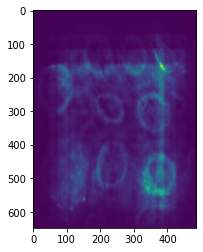